In [1]:
# Import the necessary libriries 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from keras.models import Sequential
import matplotlib.patches as mpatches
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
#Load the data into the panda data frame
data = pd.read_csv('/content/drive/MyDrive/data-sets/Weather_data.csv')

In [3]:
# visualize the first 10 rows of the data frame
data.head()

,datetime_utc,_conds,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
0,19961101-11:00,Smoke,9.0,0,0,NaN,27.0,NaN,1010.0,0,0,30.0,0,0,5.0,280.0,West,NaN,NaN,7.4
1,19961101-12:00,Smoke,10.0,0,0,NaN,32.0,NaN,-9999.0,0,0,28.0,0,0,NaN,0.0,North,NaN,NaN,NaN
2,19961101-13:00,Smoke,11.0,0,0,NaN,44.0,NaN,-9999.0,0,0,24.0,0,0,NaN,0.0,North,NaN,NaN,NaN
3,19961101-14:00,Smoke,10.0,0,0,NaN,41.0,NaN,1010.0,0,0,24.0,0,0,2.0,0.0,North,NaN,NaN,NaN
4,19961101-16:00,Smoke,11.0,0,0,NaN,47.0,NaN,1011.0,0,0,23.0,0,0,1.2,0.0,North,NaN,NaN,0.0


In [4]:
# Parse the datetime_utc into the date object so that we can perform the time series forcasting, and make the time as index column in the data frame
data['datetime_utc'] = pd.to_datetime(data['datetime_utc'])
data.set_index('datetime_utc', inplace= True)
data =data.resample('D').mean()

In [5]:
# Exptract temperature feild from the data frame
data = data[[' _tempm' ]]
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7335 entries, 1996-11-01 to 2016-11-30
Freq: D
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0    _tempm  7191 non-null   float64
dtypes: float64(1)
memory usage: 114.6 KB


In [6]:
from scipy.interpolate import interp1d
data[' _tempm'] = data[' _tempm'].interpolate()# we will fill the null row

In [9]:
data.head()

,_tempm
datetime_utc,
1996-11-01,22.333333
1996-11-02,22.916667
1996-11-03,21.791667
1996-11-04,22.722222
1996-11-05,27.800000


In [10]:
df = data.copy()

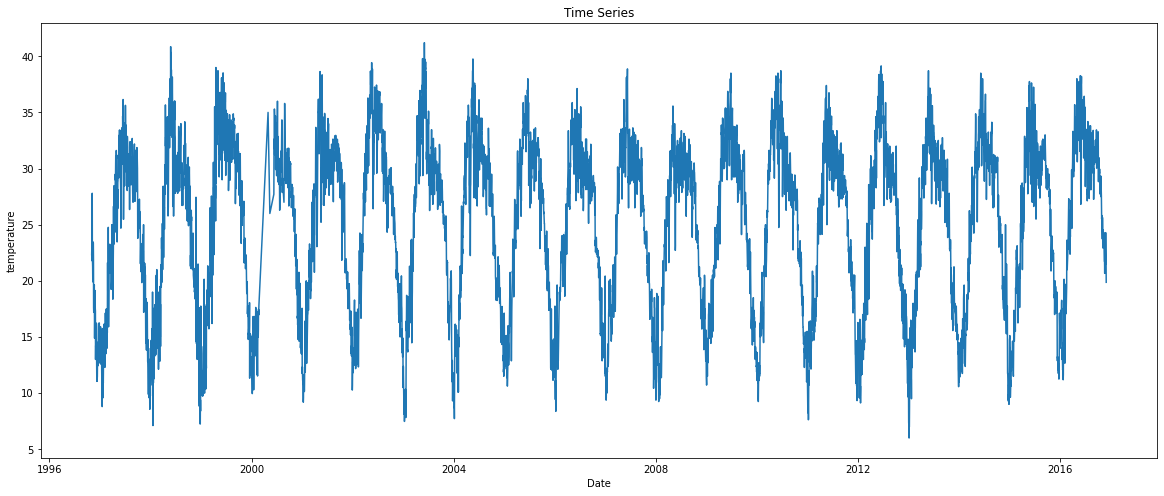

In [11]:
#Plot year wise temperature
plt.figure(figsize=(20,8))
plt.plot(data)
plt.title('Time Series')
plt.xlabel('Date')
plt.ylabel('temperature')
plt.show()

**Perform Time series forecasting using Deep Learning**

In [12]:
# Normalize the data
data=data.values
data = data.astype('float32')

In [13]:
# Normalize the data between (-1, 1)
scaler= MinMaxScaler(feature_range=(-1,1))
sc = scaler.fit_transform(data)

In [16]:
# Prepare Training and Testing Data
timestep = 30

X= []
Y=[]


for i in range(len(sc)- (timestep)):
    X.append(sc[i:i+timestep])
    Y.append(sc[i+timestep])


X=np.asanyarray(X)
Y=np.asanyarray(Y)


k = 7100
Xtrain = X[:k,:,:]
Xtest = X[k:,:,:]    
Ytrain = Y[:k]    
Ytest= Y[k:] 

In [17]:
# check the shapes of training and testing tensors
print(Xtrain.shape)
print(Xtest.shape)

(7100, 30, 1)
(205, 30, 1)


In [18]:
# Import Necessary libraires for the Deep learning Model
from keras.layers import Dense,RepeatVector
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [19]:
# Creat and compile the model
model = Sequential()
model.add(LSTM(32,activation = 'relu', input_shape= (30,1), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='sigmoid', return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 30, 32)            8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 21,025
Trainable params: 21,025
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Train the model
history = model.fit(Xtrain,Ytrain,epochs=50, verbose=1)

Epoch 1/50
222/222 [==============================] - 53s 215ms/step - loss: 0.0615
Epoch 2/50
222/222 [==============================] - 45s 203ms/step - loss: 0.0148
Epoch 3/50
222/222 [==============================] - 48s 218ms/step - loss: 0.0115
Epoch 4/50
222/222 [==============================] - 45s 202ms/step - loss: 0.0097
Epoch 5/50
222/222 [==============================] - 45s 202ms/step - loss: 0.0092
Epoch 6/50
222/222 [==============================] - 45s 201ms/step - loss: 0.0093
Epoch 7/50
222/222 [==============================] - 45s 203ms/step - loss: 0.0095
Epoch 8/50
222/222 [==============================] - 45s 202ms/step - loss: 0.0093
Epoch 9/50
222/222 [==============================] - 45s 202ms/step - loss: 0.0090
Epoch 10/50
222/222 [==============================] - 45s 202ms/step - loss: 0.0093
Epoch 11/50
222/222 [==============================] - 45s 202ms/step - loss: 0.0089
Epoch 12/50
222/222 [==============================] - 45s 203ms/step - lo

Text(0.5, 1.0, 'Model Accuracy')

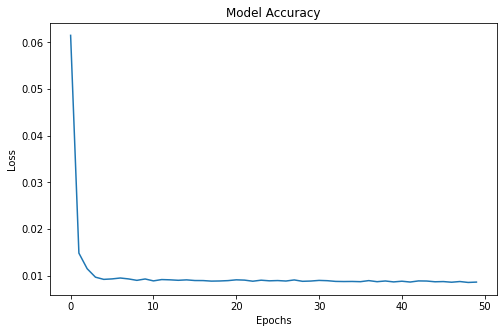

In [22]:
# Visualize the trained model accuracy
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Accuracy")

In [23]:
# Check the mse error on test data
preds= model.predict(Xtest)
preds = scaler.inverse_transform(preds)


Ytest=np.asanyarray(Ytest)  
Ytest=Ytest.reshape(-1,1) 
Ytest = scaler.inverse_transform(Ytest)


Ytrain=np.asanyarray(Ytrain)  
Ytrain=Ytrain.reshape(-1,1) 
Ytrain = scaler.inverse_transform(Ytrain)

mean_squared_error(Ytest,preds)

2.4029708

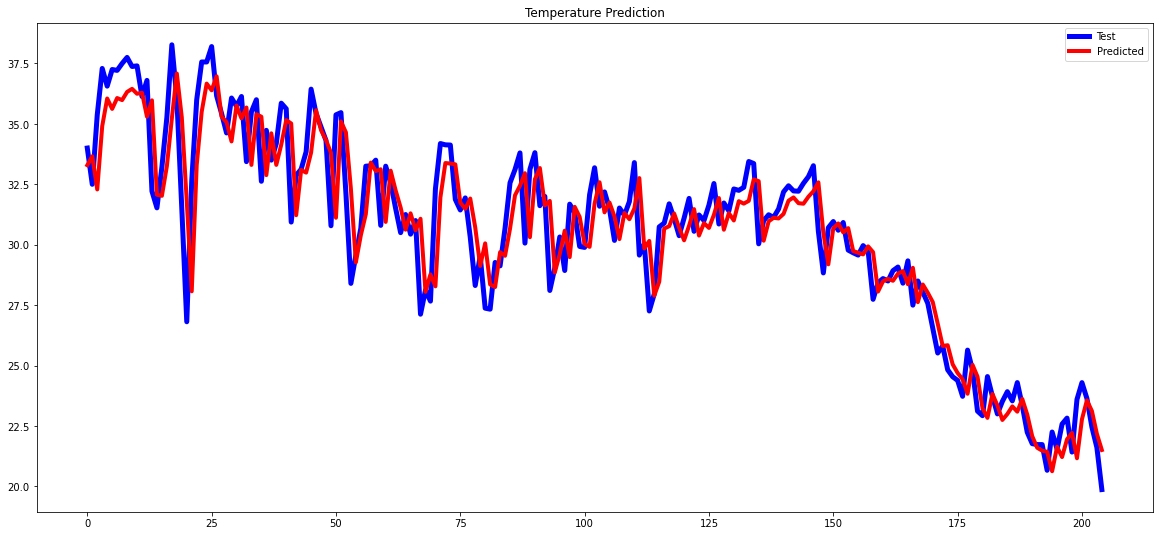

In [24]:
# Plot the prediction of the model or validation of the model
plt.figure(figsize=(20,9))
plt.plot(Ytest , 'blue', linewidth=5)
plt.plot(preds,'r' , linewidth=4)
plt.legend(('Test','Predicted'))
plt.title("Temperature Prediction")
plt.show()

In [25]:
# Create some predicted values
test = pd.DataFrame(Ytest,columns=['Actual'])
pred = pd.DataFrame(preds,columns=['Predict'])

In [27]:
# Concatinate the predicted values with historic data
results = pd.concat([test,pred],axis=1)
results.head(20)

,Actual,Predict
0,34.000000,33.291576
1,32.500000,33.660809
2,35.375004,32.288048
3,37.294117,34.909130
4,36.562500,36.051277
5,37.250000,35.620659
6,37.214287,36.069786
7,37.500000,35.984524
8,37.750000,36.322472
9,37.374996,36.451294


In [30]:

def insert_end(Xin,new_input):
    for i in range(timestep-1):
        Xin[:,i,:] = Xin[:,i+1,:]
    Xin[:,timestep-1,:] = new_input
    return Xin

In [29]:
df

,_tempm
datetime_utc,
1996-11-01,22.333333
1996-11-02,22.916667
1996-11-03,21.791667
1996-11-04,22.722222
1996-11-05,27.800000
...,...
2016-11-26,24.294118
2016-11-27,23.636364
2016-11-28,22.454545


In [31]:
# this section for unknown future for next one month
from datetime import timedelta
future=30
forcast = []
Xin = Xtest[-1:,:,:]
time=[]
for i in range(future):
    out = model.predict(Xin, batch_size=1)    
    forcast.append(out[0,0]) 
    Xin = insert_end(Xin,out[0,0]) 
    time.append(pd.to_datetime(df.index[-1])+timedelta(days=i+1))

In [32]:
forcasted_output=np.asanyarray(forcast)   
forcasted_output=forcasted_output.reshape(-1,1) 
forcasted_output = scaler.inverse_transform(forcasted_output) 

In [33]:
forcasted_output = pd.DataFrame(forcasted_output)
date = pd.DataFrame(time)
df_result = pd.concat([date,forcasted_output],axis=1)
df_result.columns = "Date","Forecasted"

In [34]:
df.columns

Index([' _tempm'], dtype='object')

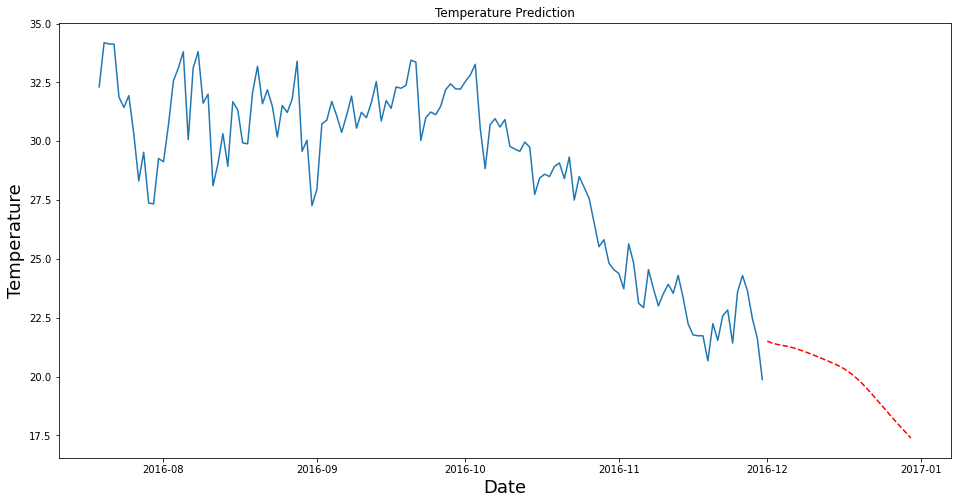

In [35]:
plt.figure(figsize=(16,8))
plt.title('Temperature Prediction')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Temperature' ,fontsize=18)
plt.plot(df[' _tempm'][7200:])
plt.plot(df_result.set_index('Date')[['Forecasted']],"r--")

In [38]:
# Save the model
model.save('/content/drive/MyDrive/weatherpredictio.h5')